# Static file cleaning
Author: Stefan Roland Schwingenschlögl <br>
email: stefan.roland.schwingenschloegl@gmail.com <br>
github: github.com/stefan-schwingenschloegl <br>
___
*Projekt File No: 2 <br>*

In this file it will be tried to get an Overview what all these files are about and if data cleaning is neccessary. For the exploratory part vizualizations based on the libraries `matplotlib` and `seaborn` will be made. 

## Import Libraries
___

In [1]:
# library for operation system controll
import os

# libraries for general data processing
import numpy as np
import pandas as pd

# libraries to display Images
from IPython.display import Image

# libraries for data vizualization
import matplotlib.pyplot as plt
import seaborn as sns

## Setting General Properties
___

In [2]:
# set consistens figure dimensions
fig_dimensions = (13, 8)

# hexadecimal colorcode from the Wiener Linien logo
wl_col = ['#e3010f', '#240b4c']

# set plot style
plt.style.use('ggplot')

# input folder path
input_folder = "./input_data/"

# define the dictionary where the changed values will be logged
changed_dict = {}

## Get a look of all downloaded files
___
In the first step all files which are downloaded will be displayed. To see which files got loaded all files will be displayed with `os` at first.

In [3]:
#get list of all filenames in data

def get_all_filenames_in_data():
    file_list = []
    for (dirpath, dirnames, filenames) in os.walk(input_folder):
        file_list.extend(filenames)
    return file_list

get_all_filenames_in_data()

['agency.txt',
 'calendar.txt',
 'calendar_dates.txt',
 'clean_fahrwegverlaeufe',
 'clean_gps-punkte',
 'clean_haltepunkte',
 'clean_haltestellen',
 'clean_linien',
 'clean_steige',
 'clean_version',
 'routes.txt',
 'shapes.txt',
 'stops.txt',
 'stop_times.txt',
 'trips.txt',
 'wienerlinien-echtzeitdaten-dokumentation.pdf',
 'wienerlinien-ogd-fahrwegverlaeufe.csv',
 'wienerlinien-ogd-gps-punkte.csv',
 'wienerlinien-ogd-haltepunkte.csv',
 'wienerlinien-ogd-haltestellen.csv',
 'wienerlinien-ogd-linien.csv',
 'wienerlinien-ogd-steige.csv',
 'wienerlinien-ogd-version.csv',
 'wienerlinien_ogd_Beschreibung.pdf']

With the 20th of November, 2020 there are three types of static files available in the *Wiener Linien* API. These are `.txt`, `.csv` and `.pdf` files. <br>

The files can be categorized as followed:
   - `.csv`: Data on the logistic coherences of the transferservice from the agency itself
   - `.pdf`: Documentation on how to use the provided data form the agency
   - `.txt`: GTFS Data (Data in the General Transfer Feed Specifictaion Format)<br>
   
In this project the data from the *Wiener Linien* will be mostly used. This is due to the fact, that most of the data is the same. So I decided that I want to use the *Wiener Linien* data since it is from the agency itself. But in a few steps the *gtfs* data is still useful. So all files will be read in in this notebook.

## Load all static files as pandas dataframes into a dictionary
___
At first all static files will be read in by pandas. To be able to read all files automatically these files will be daved inside a dictionary. The key will be generated from the names of the files.

Two examples will be given:
* generate_wl_key(`wienerlinien-ogd-fahrwegverlaeufe`) -> `fahrwegverlaeufe`
* generate_gtfs_key(`agency.txt`) -> `agency`

In the function `read_all_files` every file in the `input_data` folder will be taken and checked if it is a gtfs file (`.txt`), a *Wiener Linien* data file (`.csv`) or a *Wiener Linien* description file (`.pdf`). All gtfs files will be written into the `data_gtfs` dictionary with the key which got generated from the `generate_gtfs_key`. The same porcedure will be made with *Wiener Linien* data files. These will be written into `data` dictionary with the respective key. Description files will be ignored.

In [4]:
# generate the key for a wl file
def generate_wl_key(file_str):
    return file_str[17:-4] 

# generate the key for a gtfs file
def generate_gtfs_key(file_str):
    return file_str[:-4]

#read all data with the given suffix
def read_all_files():
    file_list = get_all_filenames_in_data()
    data = {}
    data_gtfs = {}
    for file in file_list:
        
        if file.endswith('.txt'):
            key = generate_gtfs_key(file)
            data_gtfs[key] = pd.read_csv(input_folder + file)
            pass
        else:
            try:
                key = generate_wl_key(file)
                data[key] = pd.read_csv(input_folder + file, sep = ';')
            except pd.errors.ParserError:
                continue
        
    return data_gtfs, data

# call function for loading static files
[data_gtfs, data] = read_all_files()

After loading all files sucessfully in the `data_gtfs` and `data` it will be checked if the structure is the same as on the day this script got written (20.11.2020) if there was a change in the files please use the files in the `files_20_11` folder to run this script.

In [5]:
#Check if the file structure changed compared to the version on 20.11.2020
def check_current_keys(wl_data, gtfs_data):
    wl_keys_20_11_2020 = ['fahrwegverlaeufe', 
                       'gps-punkte', 
                       'haltepunkte', 
                       'haltestellen', 
                       'linien', 
                       'steige', 
                       'version']
    
    gtfs_keys_20_11_2020 = ['agency', 
                          'calendar', 
                          'calendar_dates', 
                          'routes', 
                          'shapes', 
                          'stops', 
                          'stop_times',
                          'trips']
    
    if all(key in wl_data for key in wl_keys_20_11_2020) and all(key in gtfs_data for key in gtfs_keys_20_11_2020):
        print(f'The file structure of all data is the same as on 20.11.2020')
    else:
        print(f'There was a change in the files!' 
              f'Please use the csv files which are attached to run the code below!')
        
check_current_keys(wl_data = data, gtfs_data = data_gtfs)

The file structure of all data is the same as on 20.11.2020


After sucessfully reading all static files as pandas dataframes into the respective dictionary a closer look at the data quality of the `data` dictionary will be taken. At first the missing values are reviewed. All changes will be stored in the `changed` dictionary, where the key is the column that got manipulated and the values are the corresponding *StopID*s.

## Missing Values
___
Missing values are very disadvantageous. The quality of the analyses depends strongly on the quality of the data. An attempt should be made to minimise the missing values as far as possible. First, these missing values are made visible in the *Wiener Linien* data. This is done with the help of a `heatmap` of the library `seaborn`. In this case, each missing value is represented by a blue row. If there is no missing value, this row is coloured red. The advantage of this representation is that the ratio of missing to not missing values can be estimated quickly. It is also possible to see whether missing values occur frequently or are distributed individually in the data.

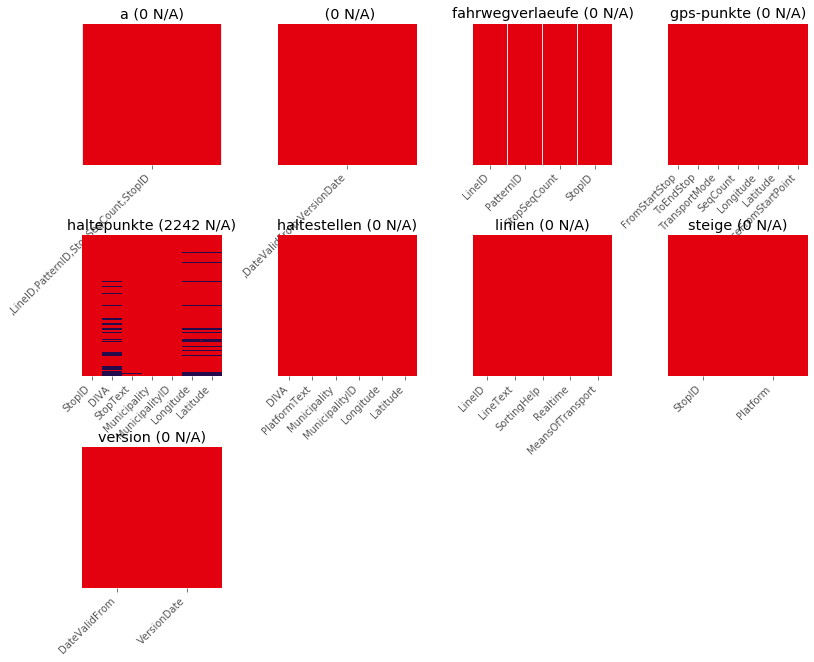

In [6]:
#generate the amount of rows from the dataframes inside the data dictionary
def get_subplot_rows(data):
    sub_rows = np.ceil(len(data)/4).astype('int16')
    return sub_rows

def get_amount_of_na(data, key):
    amount = data[key].isna().sum().sum().astype(str)
    return amount
    
def print_na(data):
    sub_rows = get_subplot_rows(data)
    
    #set general specifications
    sub_grid = (sub_rows,4)
    fig, axs = plt.subplots(sub_grid[0], sub_grid[1], figsize=fig_dimensions)
    row=0
    i=0
    
    #plot each of the subplot
    for key in data.keys():
        col=np.mod(i,4)
        sns.heatmap(data[key].isna(),
                ax = axs[row,col],
                yticklabels=False,
                vmin=0,
                vmax=1,
                cmap=sns.color_palette(wl_col),
                cbar=False)

        
        #set title for every subplot
        axs[row,col].set_title(f'{key} ({get_amount_of_na(data, key)} N/A)')
        axs[row,col].set_xticklabels(axs[row,col].get_xticklabels(), 
                                     rotation=45,
                                     ha='right')
        
        #break row after 4 subplots
        if col == 3:
            row+=1
        i+=1
    
    #drop axis of all unused subplots
    if np.mod(len(data), 4) != 0:
        for i in range(1,np.mod(4 - np.mod(len(data),4), 4) + 1):
            axs[-1,-i].axis('off')
    
    #adjust the space between the subplots 
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)


print_na(data)

After visualisation, it can be seen that only the fdataframe `haltepunkte` contains missing values. Therefore only this one is treated with the missing values. In all other data there are no missing values.

After visualisation, it can be seen that only the file `haltepunkte` contains missing values. Therefore only this one is treated with the missing values. In all other data there are no missing values. In order to be able to clean up the dataframe `haltepunkte`, we first look at what information is stored in this dataframe. For this purpose the document `wienerlinien_ogd_Beschreibung.pdf` is used, which was downloaded simultaneously with the datafiles and is currently stored inside `input_data`. The date of the download of this document in this file is 20.11.2020.

### Analysis of `haltepunkte.csv`
___

In [7]:
data['haltepunkte'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4971 entries, 0 to 4970
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   StopID          4971 non-null   int64  
 1   DIVA            4050 non-null   float64
 2   StopText        4938 non-null   object 
 3   Municipality    4971 non-null   object 
 4   MunicipalityID  4971 non-null   int64  
 5   Longitude       4327 non-null   float64
 6   Latitude        4327 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 272.0+ KB


The dataframe `haltepunkte` consists of 4971 entries and have 6 columns. These are (description taken from  `wienerlinien_ogd_Beschreibung.pdf`):
* StopID: Identifier for stopping position
* DIVA: Summary of multiple Stops of a Station area
* StopText: Name of the stopping position
* Muncipality: Name of the municipality (Note: currently "Wien")
* MunicipalityID: Unique ID of the municipality (Note: currently "90001")
* Longitude: Geographical longitude of stopping position 
* Latitude: Geographical latitude of stopping position

Since two columns are stated that their value are default a first check will be made.

In [8]:
# check if all values are the stated default values
print(f"Column 'Municipality' only consists of value 'Wien': {set(data['haltepunkte']['Municipality'].unique()) == {'Wien'}}")
print(f"Column 'MunicipalityID' only consists of value '90001': {set(data['haltepunkte']['MunicipalityID'].unique()) == {90001}}")

Column 'Municipality' only consists of value 'Wien': True
Column 'MunicipalityID' only consists of value '90001': True


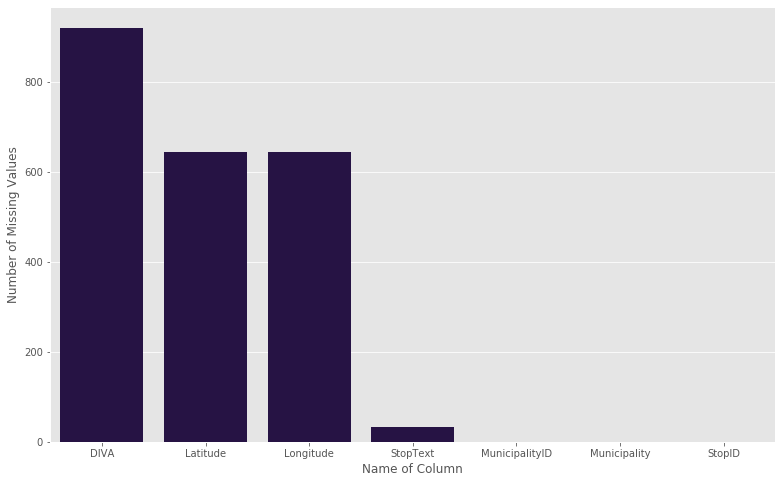

In [9]:
plt.figure(figsize=fig_dimensions)
chart=sns.barplot(x=data['haltepunkte'].isna().sum().index,
            y=data['haltepunkte'].isna().sum(),
            order=data['haltepunkte'].isna().sum().sort_values(ascending=False).index,
            color = wl_col[1])
_=chart.set(xlabel='Name of Column', ylabel='Number of Missing Values')

In this figure it can be seen, that most of the missing values are in the feature *DIVA*, followed by *Latitude* and *Longitude*. Only a few missing values are in the column with the *StopText*.<br> 
At first lets take a closer look at the missing values from the *StopText*. <br>

#### Missing Values in Column *StopText*
___
In this section the dataframe will be sliced to get all entries where *StopText* is not available. For further processing this subset will be saved to a dataframe named `temp`.

In [10]:
# get all entries where StopText is NA
temp = data['haltepunkte'].loc[data['haltepunkte']['StopText'].isna()]
temp

,StopID,DIVA,StopText,Municipality,MunicipalityID,Longitude,Latitude
2827,3134,60200137.0,NaN,Wien,90001,16.354078,48.191114
3877,5653,60200849.0,NaN,Wien,90001,16.358040,48.180762
4273,7310,NaN,NaN,Wien,90001,NaN,NaN
4274,7311,NaN,NaN,Wien,90001,NaN,NaN
4275,7312,NaN,NaN,Wien,90001,NaN,NaN
4276,7313,NaN,NaN,Wien,90001,NaN,NaN
4277,7314,NaN,NaN,Wien,90001,NaN,NaN
4278,7315,NaN,NaN,Wien,90001,NaN,NaN
4279,7316,NaN,NaN,Wien,90001,NaN,NaN
4280,7317,NaN,NaN,Wien,90001,NaN,NaN


It can be seen, that most of the missing values at the *Stop Text* column just have a unique *StopID* Number and the default values at *Municipality* and *MunicipalityID*. Since there are not even values for the Coordinates I can not assign these values. Therefore these Stops will be removed from the dataframe. But it should be asked where these Stops are. To not lose this information the removed stops will be saved to another dataframe. <br>
Possible scenarios:
- These Stops are planned but currently not in use.
- Maybe these Stops are relevant for internal use. <br>

Ways to find out:
- Ask the agency about these stops
- Maybe it could be found out where these stops could be if there is a logic behind the allocation of the StopIDs. <br>

The second thing that stands out is that there are two stops which have a *DIVA* number but no *StopText*. These two entries will be investigated further.

In order to do that the two DIVAs available in `temp` will be extracted and all stops with these DIVAs from `haltepunkte` will be displayed.

In [11]:
# log dropped StopIDs
for stop_id in data['haltepunkte'].loc[(data['haltepunkte']['DIVA'].isna()) & data['haltepunkte']['StopText'].isna(), 'StopID'].unique():
    if "dropped_record" in changed_dict:
          changed_dict["dropped_record"].append(stop_id)
    else:
          changed_dict["dropped_record"] = [stop_id]

#print(changed_dict)

In [12]:
data['haltepunkte'] = data['haltepunkte'][~data['haltepunkte']['StopID'].isin(changed_dict['dropped_record'])]

In [13]:
def get_stops_with_DIVA(df, temp):
    DIVA_list = temp.loc[temp['DIVA'].notna(), 'DIVA'].unique()
    return df.loc[df['DIVA'].isin(DIVA_list)]

get_stops_with_DIVA(data['haltepunkte'], temp)

,StopID,DIVA,StopText,Municipality,MunicipalityID,Longitude,Latitude
367,400,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.358719,48.180593
392,426,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.359265,48.180492
677,756,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.359357,48.180388
689,768,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.359390,48.180529
693,772,60200137.0,Bezirksamt Margareten,Wien,90001,16.355290,48.190728
771,851,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.359428,48.180875
2827,3134,60200137.0,NaN,Wien,90001,16.354078,48.191114
3303,3853,60200849.0,Matzleinsdorfer Platz S,Wien,90001,16.358896,48.179181
3877,5653,60200849.0,NaN,Wien,90001,16.358040,48.180762
3898,5674,60200849.0,Matzleinsdorfer Platz,Wien,90001,16.357443,48.180156


It can be seen that, these Stops are at the *Matzleinsdorfer Platz* and *Bezirksamt Margereten*. After searching for relevant information, it turned out that construction work is currently underway at both sites (see screenshot below | Source: https://www.wien.gv.at/verkehr/baustellen/aktuell/ | processed: 23.11.2020). This may have something to do with this. This should be investigated subsequently.

For now the *StopText* will be set at the mode of the *StopTexts* from the stops with the same *DIVA* number.

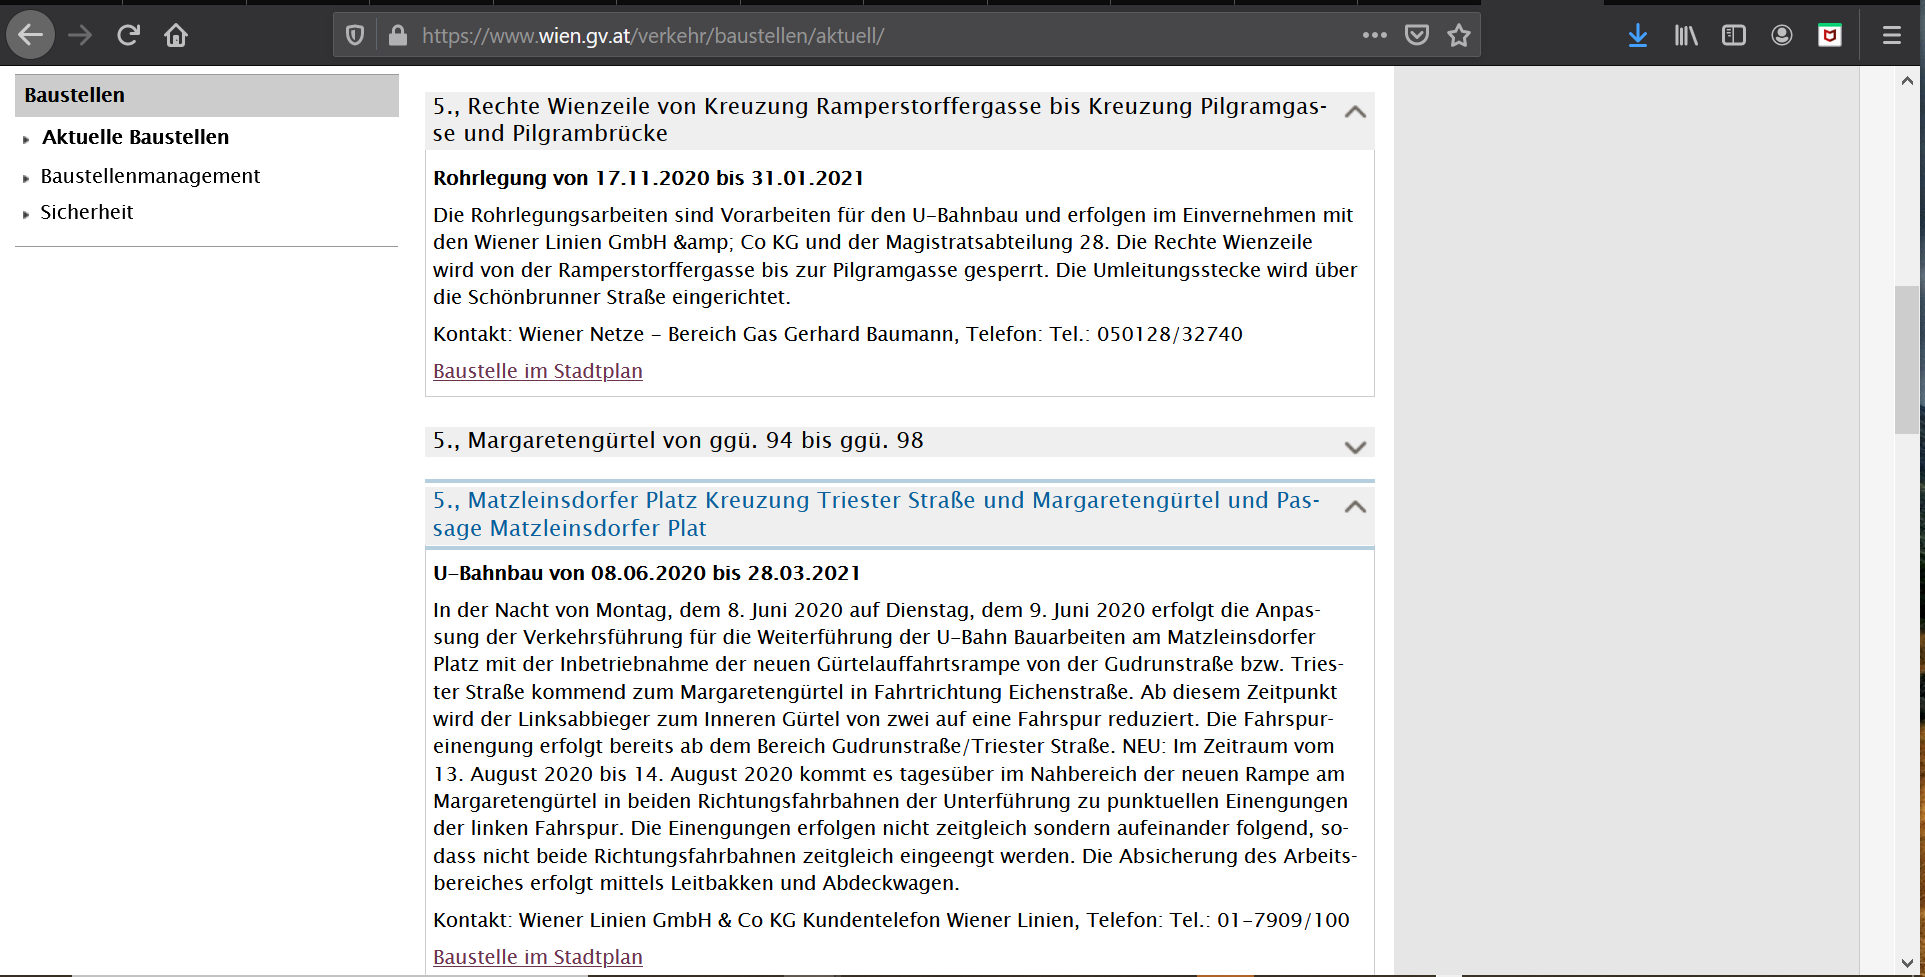

In [14]:
Image("./img/construction_sites.PNG")

In [15]:
# log changed StopIDs
for stop_id in temp.loc[temp['DIVA'].notna(), 'StopID'].unique():
    if "replaced_StopText" in changed_dict:
          changed_dict["replaced_StopText"].append(stop_id)
    else:
          changed_dict["replaced_StopText"] = [stop_id]

#print(changed_dict)

In [16]:
# set all unnamed stops with known DIVA number to mode text of DIVA number

def replace_known_DIVA_with_mode_stoptext(df):
    print(f'NA Values before:\n{df.isna().sum()}\n')
    
    # get the mode of the StopText of each DIVA number
    group_mode = df.groupby('DIVA').agg(lambda x: x.mode()).reset_index()[['DIVA', 'StopText']]
    
    # merge the dataframe with the missing values and the one with the mode
    df = df.merge(group_mode[['DIVA', 'StopText']],on='DIVA', how='left')
    
    # fill the missing values with the value from the mode column
    df['StopText'] = df['StopText_x'].fillna(df['StopText_y'])
    
    # drop the unnecessary columns
    df = df.drop(columns=['StopText_x', 'StopText_y'])
    
    print(f'NA Values after:\n{df.isna().sum()}')
    
    return df

data['haltepunkte'] = replace_known_DIVA_with_mode_stoptext(data['haltepunkte'])

NA Values before:
StopID              0
DIVA              890
StopText            2
Municipality        0
MunicipalityID      0
Longitude         613
Latitude          613
dtype: int64

NA Values after:
StopID              0
DIVA              890
Municipality        0
MunicipalityID      0
Longitude         613
Latitude          613
StopText            0
dtype: int64


In [17]:
# check changed records
data['haltepunkte'][data['haltepunkte']['StopID'].isin(changed_dict['replaced_StopText'])]

,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText
2827,3134,60200137.0,Wien,90001,16.354078,48.191114,Bezirksamt Margareten
3877,5653,60200849.0,Wien,90001,16.358040,48.180762,Matzleinsdorfer Platz S


It can be seen that the two NA values at the columns *StopText* are now gone. These are set with the mode of the StopText from the corresponding DIVA number. So this column got cleaned. In the next step the *Latitude* and *Longitude* will be observed.

#### Missing Values in *Latitude* & *Longitude*
___
After looking for the missing values in the *StopText* column, the values in the missing values in the *Longitude* and *Latitude* columns will be inspected. In each column are 613 missing values. In the first step it will be investigated if the missing values are always ocurring together.

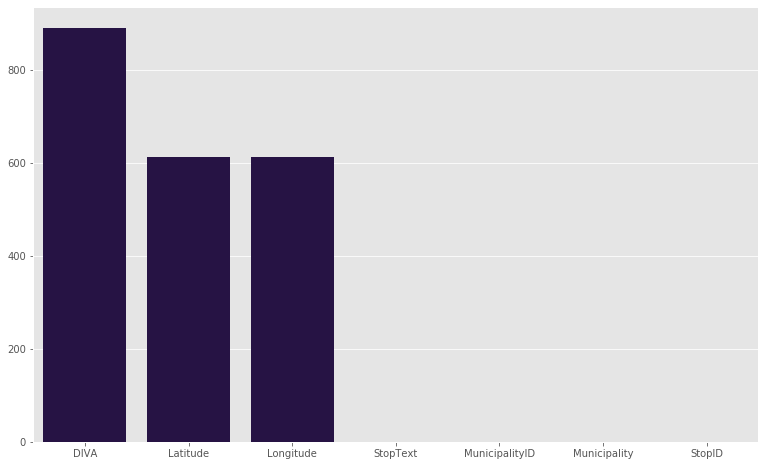

In [18]:
plt.figure(figsize=fig_dimensions)
Chart = sns.barplot(x=data['haltepunkte'].isna().sum().index,
                    y=data['haltepunkte'].isna().sum(),
                    order=data['haltepunkte'].isna().sum().sort_values(ascending=False).index,
                    color = wl_col[1])
_=chart.set(xlabel='Name of Column', ylabel='Number of Missing Values')

In [19]:
# function to get the rows with exact number of missing over two columns
def get_missing_combined(df, c1, c2, number_na):
    sub_set = df.loc[df[[c1, c2]].isna().sum(axis=1) == number_na]
    print(f'There are {len(sub_set)} of rows with exactly {number_na} missing value over columns{c1, c2}.')
    return sub_set

# get subset where either longitude or latitude but not both values in one row are missing
get_missing_combined(data['haltepunkte'], 'Longitude', 'Latitude', 1)

There are 0 of rows with exactly 1 missing value over columns('Longitude', 'Latitude').


,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText


In [20]:
# get subset where longitude and latitude are both missing
long_lat_missing = get_missing_combined(data['haltepunkte'], 'Longitude', 'Latitude', 2)

There are 613 of rows with exactly 2 missing value over columns('Longitude', 'Latitude').


In [21]:
long_lat_missing

,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText
19,26,NaN,Wien,90001,NaN,NaN,Praterstern S U
45,56,60200544.0,Wien,90001,NaN,NaN,Hoher Markt
50,61,NaN,Wien,90001,NaN,NaN,Gänsehäufel
55,66,NaN,Wien,90001,NaN,NaN,Kaisermühlen VIC U
59,70,NaN,Wien,90001,NaN,NaN,Neue Donau Mitte
...,...,...,...,...,...,...,...
4935,9405,NaN,Wien,90001,NaN,NaN,Bahngasse/Kasematten
4936,9500,NaN,Wien,90001,NaN,NaN,Rochusgasse (DUMMY Marathon)
4937,9900,NaN,Wien,90001,NaN,NaN,Salmannsdorf Dummy
4938,9989,NaN,Wien,90001,NaN,NaN,"Bhf. Hetzendorf, Altmann"


In [22]:
get_missing_combined(long_lat_missing, 'DIVA', 'Latitude', 1)

There are 183 of rows with exactly 1 missing value over columns('DIVA', 'Latitude').


,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText
45,56,60200544.0,Wien,90001,NaN,NaN,Hoher Markt
71,89,60200457.0,Wien,90001,NaN,NaN,Habsburgergasse
206,229,60200508.0,Wien,90001,NaN,NaN,Bhf.Hls. - Bedarfshaltes
282,309,60201040.0,Wien,90001,NaN,NaN,Praterstern
401,436,60201070.0,Wien,90001,NaN,NaN,Rappachgasse
...,...,...,...,...,...,...,...
4115,6000,60200033.0,Wien,90001,NaN,NaN,Altes Landgut
4562,8638,60201649.0,Wien,90001,NaN,NaN,Kornblumenweg
4834,9000,60201349.0,Wien,90001,NaN,NaN,Dummy 1
4846,9012,60200839.0,Wien,90001,NaN,NaN,Dummy 12


It can be seen that there are missing values at the Longitude and Latitude columns which have a DIVA number. It does not matter that only column out of [*longitude*, *latitude*] is passed as an argument, as before it could be seen that these columns are always missing together. The missing values for the coordinates will be filled with the default coordinates for the DIVA number which is stored in `data[haltestellen]`.
#### Get Coordinates from `data[haltestellen]` based on *DIVA* number
___

In [23]:
# get subset of all entries where coordinates are missing but DIVA is available
temp = long_lat_missing.loc[long_lat_missing['DIVA'].notna()]

In [24]:
# left inner join between haltepunkte_df and haltestellen_df on DIVA number to get default coordinates of DIVA for stop
temp2 = temp.merge(data['haltestellen'][['DIVA', 'Longitude', 'Latitude']], on = 'DIVA', how='left')

In [25]:
data['haltepunkte'] = data['haltepunkte'].merge(temp2[['DIVA', 'Longitude_y', 'Latitude_y']],
                                                on='DIVA',
                                                how='left')
data['haltepunkte']

,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText,Longitude_y,Latitude_y
0,3,NaN,Wien,90001,16.406672,48.217989,Messe Prater,NaN,NaN
1,5,60200195.0,Wien,90001,16.364621,48.215987,Börse,NaN,NaN
2,7,60201848.0,Wien,90001,16.394717,48.220079,"Praterstern, Lassallestraße",NaN,NaN
3,8,60201349.0,Wien,90001,16.375554,48.186074,Hauptbahnhof S U,16.376413,48.185188
4,8,60201349.0,Wien,90001,16.375554,48.186074,Hauptbahnhof S U,16.376413,48.185188
...,...,...,...,...,...,...,...,...,...
5387,9405,NaN,Wien,90001,NaN,NaN,Bahngasse/Kasematten,NaN,NaN
5388,9500,NaN,Wien,90001,NaN,NaN,Rochusgasse (DUMMY Marathon),NaN,NaN
5389,9900,NaN,Wien,90001,NaN,NaN,Salmannsdorf Dummy,NaN,NaN
5390,9989,NaN,Wien,90001,NaN,NaN,"Bhf. Hetzendorf, Altmann",NaN,NaN


In [26]:
# replace missing coordinates with default values of DIVA from data['haltestellen'] 
data['haltepunkte']['Longitude'] = data['haltepunkte']['Longitude'].fillna(data['haltepunkte']['Longitude_y'])
data['haltepunkte']['Latitude'] = data['haltepunkte']['Latitude'].fillna(data['haltepunkte']['Latitude_y'])

In [27]:
# log entries which got filled with default coordinates
for stop_id in temp['StopID'].unique():
    if "filled_default_DIVA_coordinates" in changed_dict:
          changed_dict["filled_default_DIVA_coordinates"].append(stop_id)
    else:
          changed_dict["filled_default_DIVA_coordinates"] = [stop_id]

In [28]:
#drop unnecessary columns from haltestellen_df
data['haltepunkte'] = data['haltepunkte'].drop(columns=['Longitude_y', 'Latitude_y'])

In [29]:
data['haltepunkte'].isna().sum()

StopID              0
DIVA              890
Municipality        0
MunicipalityID      0
Longitude         430
Latitude          430
StopText            0
dtype: int64

Following this measure, it can be seen that the number of missing coordinates has been reduced to 430. Now, in the next step, it will be checked whether there are still entries with existing DIVA in the data record. 

In [30]:
# if there are any records with DIVA and without coordinates
data['haltepunkte'].loc[data['haltepunkte']['DIVA'].notna() & data['haltepunkte']['Longitude'].isna()]

,StopID,DIVA,Municipality,MunicipalityID,Longitude,Latitude,StopText


There are no longer any entries with DIVA numbers for which the coordinates are missing. In the next step it will be tried to merge the *StopText* with the one of the `data['haltestellen']`.

#### Get Coordinates from `data[haltestellen]` based on exact same *StopText* 
___

In [31]:
# get subset of all entries with missing coordinates
temp = data['haltepunkte'].loc[data['haltepunkte']['Longitude'].isna()]

In [32]:
data['haltestellen'][['PlatformText', 'Longitude', 'Latitude']]

,PlatformText,Longitude,Latitude
0,Schrankenberggasse,16.389807,48.173801
1,Achengasse,16.448898,48.284526
2,Ada-Christen-Gasse,16.385954,48.152866
3,Adam-Betz-Gasse,16.535191,48.215611
4,Adamovichgasse,16.337840,48.142167
...,...,...,...
11084,St. Martin/Weitra Bahnhof,14.841318,48.663387
11085,Steinbach-Bad Großpertholz Bf,14.842190,48.640278
11086,Weitersfeld Bahnhof,15.805866,48.787736
11087,Weitra Bahnhof,14.901757,48.700823


In [33]:
temp_merged = temp[['StopID', 'StopText', 'Longitude', 'Latitude']].merge(data['haltestellen'][['PlatformText', 'Longitude', 'Latitude']],
                                                                left_on = 'StopText',
                                                                right_on= 'PlatformText')

In [34]:
data['haltepunkte'] = data['haltepunkte'].merge(temp_merged[['StopText', 'Longitude_y', 'Latitude_y']],
                                                on='StopText',
                                                how='left')

In [35]:
data['haltepunkte'].isna().sum()

StopID               0
DIVA               960
Municipality         0
MunicipalityID       0
Longitude          494
Latitude           494
StopText             0
Longitude_y       4999
Latitude_y        4999
dtype: int64

In [36]:
# replace missing coordinates with default values of DIVA from data['haltestellen'] 
data['haltepunkte']['Longitude'] = data['haltepunkte']['Longitude'].fillna(data['haltepunkte']['Longitude_y'])
data['haltepunkte']['Latitude'] = data['haltepunkte']['Latitude'].fillna(data['haltepunkte']['Latitude_y'])

In [37]:
# log entries which got filled with coordinates from StopText join
for stop_id in temp_merged['StopID'].unique():
    if "filled_join_string_coordinates" in changed_dict:
          changed_dict["filled_join_string_coordinates"].append(stop_id)
    else:
          changed_dict["filled_join_string_coordinates"] = [stop_id]

In [38]:
#drop unnecessary columns from haltestellen_df
data['haltepunkte'] = data['haltepunkte'].drop(columns=['Longitude_y', 'Latitude_y'])

In [39]:
data['haltepunkte'].isna().sum()

StopID              0
DIVA              960
Municipality        0
MunicipalityID      0
Longitude         310
Latitude          310
StopText            0
dtype: int64

At the moment the number of mssing values for the coordinates was reduced from over 600 entries to 310.

#### Get Coordinates from `data[haltepunkte]` based on exact match on *StopText*
___

In the next approach all entries are taken which do not have coordinates. If any stop with the exact same name information has coordinates, then this value should be set. In the first step all stations with coordinates are taken out. After that only the *StopText* is sliced and all duplicates are removed. This helps to ensure that only one pair of coordinates is set per match when joining later. From these unique *StopText* with coordinates the indices are stored afterwards. Afterwards all rows with these indices are selected as subset of `data['haltepunkte']` and joined with the whole `data['haltepunkte']`. In this column all NA values in `data['haltepunkte']` are filled with the values of the subset. All indices got logged in the `changed_dict` with the key `filled_lookup_StopText_coordinates`.


In [40]:
# get all entries with missing coordinates and select the name of the station
av = data['haltepunkte'].loc[data['haltepunkte']['Longitude'].notna(),['StopText']]

In [41]:
# drop all duplicates 
av = av.drop_duplicates()

In [42]:
lookup_df = data['haltepunkte'].loc[data['haltepunkte'].index.isin(av.index),['StopText','Longitude', 'Latitude']]

In [43]:
temp = data['haltepunkte'].loc[data['haltepunkte']['Longitude'].isna()]

In [44]:
replaced_ids = temp.merge(lookup_df,
                   on='StopText')['StopID']

In [45]:
data['haltepunkte'] = data['haltepunkte'].merge(lookup_df[['StopText', 'Longitude', 'Latitude']],
                          on='StopText',
                          how='left')

In [46]:
# replace missing coordinates with default values of DIVA from data['haltestellen'] 
data['haltepunkte']['Longitude'] = data['haltepunkte']['Longitude_x'].fillna(data['haltepunkte']['Longitude_y'])
data['haltepunkte']['Latitude'] = data['haltepunkte']['Latitude_x'].fillna(data['haltepunkte']['Latitude_y'])

In [47]:
# drop unnecessary columns from haltestellen_df
data['haltepunkte'] = data['haltepunkte'].drop(columns=['Longitude_x','Longitude_y', 'Latitude_x', 'Latitude_y'])

In [48]:
# log changed StopIDs
for stop_id in replaced_ids:
    if "filled_lookup_StopText_coordinates" in changed_dict:
          changed_dict["filled_lookup_StopText_coordinates"].append(stop_id)
    else:
          changed_dict["filled_lookup_StopText_coordinates"] = [stop_id]

#print(changed_dict)

In [49]:
data['haltepunkte'].isna().sum()

StopID              0
DIVA              960
Municipality        0
MunicipalityID      0
StopText            0
Longitude         255
Latitude          255
dtype: int64

Now the amount of missing values in the coordinates got further reduced to 255.

#### Get Coordinates from `data_gtfs['stops']` based on based on exact match on *StopText*
___
Next it will be tried to join this dataframe with `data_gtfs['stops']`. In this dataframe there are also coordinates available. The problem is that a join over the name is very instable. One different character in the stop text and there is no match between the keys.

In [50]:
# get subset with entries with missing coordinates
temp_wl = data['haltepunkte'].loc[data['haltepunkte']['Longitude'].isna()]

In [51]:
# merge this subset with 
exact_match = temp_wl.merge(data_gtfs['stops'],
                            left_on='StopText',
                            right_on='stop_name')[['StopID', 'stop_lon', 'stop_lat']]

In [52]:
# there are two matches with different coordinates. I will take only the first one to be consistent
exact_match = exact_match.iloc[[0]]

In [53]:
# merge this record to the original dataframe
data['haltepunkte'] = data['haltepunkte'].merge(exact_match,
                                                left_on='StopID',
                                                right_on='StopID',
                                                how='left')

In [54]:
# replace missing coordinates with exact matches from data_gtfs['stops']
data['haltepunkte']['Longitude'] = data['haltepunkte']['Longitude'].fillna(data['haltepunkte']['stop_lon'])
data['haltepunkte']['Latitude'] = data['haltepunkte']['Latitude'].fillna(data['haltepunkte']['stop_lat'])

In [55]:
# log changed StopIDs
for stop_id in exact_match['StopID']:
    if "filled_exact_match_gtfs_coordinates" in changed_dict:
          changed_dict["filled_exact_match_gtfs_coordinates"].append(stop_id)
    else:
          changed_dict["filled_exact_match_gtfs_coordinates"] = [stop_id]

#print(changed_dict)

In [56]:
# drop unnecessary columns from haltestellen_df
data['haltepunkte'] = data['haltepunkte'].drop(columns=['stop_lon','stop_lat'])

In [57]:
# get amount of missing data
data['haltepunkte'].isna().sum()

StopID              0
DIVA              960
Municipality        0
MunicipalityID      0
StopText            0
Longitude         254
Latitude          254
dtype: int64

#### Fazit of missing values for coordinates
___
After this step a total of 254 missing values are left. Compared to the over 600 entries at the begin this is quite a replacement. If necessary further cleaning would be recommended. Additional ideas would be to use fuzzy string matching with the levenstein metric. This metric computes how similar two strings are. With this score a treshhold can be made and if the score is higher than the threshold it will be recognized as a match.

### Missing Values for *DIVA*
___
Additionally I will not clean any of the missing DIVA numbers since there could stops which are so isolated that there is no other stop nearby. Without a close stop, there can be no 'Summary of multiple Stops of a Station area'. 


# Next Steps
___
Due to the fact that in the following project it is not necessary to get all missing values out of the data it will be left at this point. All inspected dataframes will be saved as a csv with the prefix **cleaned_** + their respective name to the folder `input_data`.

In the next step a database will be created and all cleaned static files will be loaded in there. This will be made in the `create_database.ipynb`.

In [92]:
# write all dataframes as .csv to input_data
for file in data.keys():
    filename =  'clean_' + file
    data[file].to_csv(input_folder + filename)